# CNN with MNIST Dataset
* Notebook coded by Adam Lang
* Date: 4/30/2024
* This was a code along as part of the course Deep Learning for Medical Image Analysis taught by Professor Jose Portilla from Udemy.

* In the previous notebook we build an ANN or MLP or simple neural network to predict and classify the images from the famous MNIST dataset and evaluate the results. We were able to see how poorly the ANN handles imaging data and we will now implement a CNN network to see if it can improve upon the results.

* More details about the MNIST dataset: https://en.wikipedia.org/wiki/MNIST_database
* The MNIST database (Modified National Institute of Standards and Technology database) is a large collection of handwritten digits. It has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger NIST Special Database 3 (digits written by employees of the United States Census Bureau) and Special Database 1 (digits written by high school students) which contain monochrome images of handwritten digits. The digits have been size-normalized and centered in a fixed-size image. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image by computing the center of mass of the pixels, and translating the image so as to position this point at the center of the 28x28 field. (source: https://paperswithcode.com/dataset/mnist)

## Import libraries

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline

## Load the MNIST Dataset

In [2]:
# load data
transform = transforms.ToTensor()

In [3]:
## load data into train and test
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transform)

test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transform)

100%|██████████| 9912422/9912422 [04:56<00:00, 33402.64it/s]


Extracting ../Data/MNIST/raw/train-images-idx3-ubyte.gz to ../Data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 2728527.21it/s]


Extracting ../Data/MNIST/raw/train-labels-idx1-ubyte.gz to ../Data/MNIST/raw



100%|██████████| 1648877/1648877 [00:49<00:00, 33139.97it/s]


Extracting ../Data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../Data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 3479548.63it/s]


Extracting ../Data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../Data/MNIST/raw



In [4]:
## view train_data
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [5]:
## view test_data
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

## DataLoaders and Batch Sizes

In [6]:
## instantiate the DataLoader and Batch Size (this depends on your operating system and intent)
train_loader = DataLoader(train_data, batch_size=10, shuffle=True) #shuffle data so we don't overfit

test_loader = DataLoader(test_data, batch_size=10, shuffle=False) # we don't need to shuffle the test_data only train_data

## Define a Convolutional Model (CNN)
n the previous section we used only fully connected layers, with an input layer of 784 (our flattened 28x28 images), hidden layers of 120 and 84 neurons, and an output size representing 10 possible digits.

This time we'll employ two convolutional layers and two pooling layers before feeding data through fully connected hidden layers to our output. The model follows CONV/RELU/POOL/CONV/RELU/POOL/FC/RELU/FC.

Let's walk through the steps we're about to take.
Extend the base Module class:
class ConvolutionalNetwork(nn.Module):
    def __init__(self):
        super().__init__()

Set up the convolutional layers with torch.nn.Conv2d()

The first layer has one input channel (the grayscale color channel). We'll assign 6 output channels for feature extraction. We'll set our kernel size to 3 to make a 3x3 filter, and set the step size to 1.
    self.conv1 = nn.Conv2d(1, 6, 3, 1)
The second layer will take our 6 input channels and deliver 16 output channels.
    self.conv2 = nn.Conv2d(6, 16, 3, 1)


Set up the fully connected layers with torch.nn.Linear().

The input size of (5x5x16) is determined by the effect of our kernels on the input image size. A 3x3 filter applied to a 28x28 image leaves a 1-pixel edge on all four sides. In one layer the size changes from 28x28 to 26x26. We could address this with zero-padding, but since an MNIST image is mostly black at the edges, we should be safe ignoring these pixels. We'll apply the kernel twice, and apply pooling layers twice, so our resulting output will be (((28−2)/2)−2)/2=5.5 which rounds down to 5 pixels per side.
    self.fc1 = nn.Linear(5*5*16, 120)
    self.fc2 = nn.Linear(120, 84)
    self.fc3 = nn.Linear(84, 10)
See below for a more detailed look at this step.


Define the forward method.

Activations can be applied to the convolutions in one line using F.relu() and pooling is done using F.max_pool2d()
def forward(self, X):
    X = F.relu(self.conv1(X))
    X = F.max_pool2d(X, 2, 2)
    X = F.relu(self.conv2(X))
    X = F.max_pool2d(X, 2, 2)
Flatten the data for the fully connected layers:
    X = X.view(-1, 5*5*16)
    X = F.relu(self.fc1(X))
    X = self.fc2(X)
    return F.log_softmax(X, dim=1)


# Breaking down the convolutional layers (this code is for illustration purposes only.)

This is the docstring for the `Conv2d` that we are using for parameters:

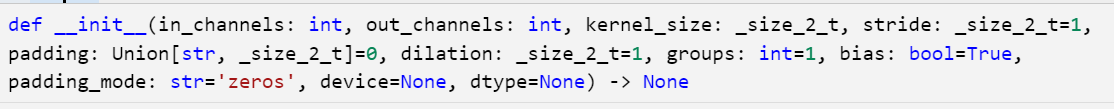

In [7]:
# these are breakdown examples

# 1 (first convolutional layer) COLOR CHANNEL, 6 FILTERS (OUTPUT CHANNELS), 3x3 KERNEL, STRIDE=1
conv1 = nn.Conv2d(in_channels=1,out_channels=6,kernel_size=3,stride=1) # ---> 6 filters --> pooling --> conv2

# 2 (second convolutional layer) --> 6 input filters from Conv1, 16 filters (arbitrary), 3x3 KERNEL, STRIDE=1
conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=3,stride=1)

In [10]:
## Next step is to grab the first MNIST record
for i, (X_train, y_train) in enumerate(train_data):
    break

In [11]:
## X_train shape
X_train.shape # ---> convert to 4D batch (batch of 1 image)

torch.Size([1, 28, 28])

Note: Right now we have 1 batch with 28x28 color channels.

In [13]:
## conversion to 4D batch
x = X_train.view(1,1,28,28)

In [15]:
## perform first convolution
x = F.relu(conv1(x))

In [16]:
## check shape
x.shape

torch.Size([1, 6, 26, 26])

Summary:
* 1 image
* 6 filters
* 26 x 26 image --- wait wasn't it 28x28?
    * It is now "convoluted"
    * Lost some of the image border.
    * We did not add any padding to MNIST because its not necessary (there aren't any details on the image edge to be concerned with)

In [19]:
## call pooling layer
x = F.max_pool2d(x,2,2)

In [20]:
## check x shape
x.shape

torch.Size([1, 6, 13, 13])

What happened now?
* We cut the size in half with `max_pool2d`

In [21]:
## one last pass
x = F.relu(conv2(x))

In [22]:
## check shape
x.shape

torch.Size([1, 16, 11, 11])

In [23]:
## another max_pool2d
x = F.max_pool2d(x,2,2)

In [24]:
x.shape

torch.Size([1, 16, 5, 5])

In [25]:
11/2

5.5

Final size of 5.5 --> rounded to 5

In [26]:
## math of these convolutions
(((28-2)/2)-2)/2


5.5

We then feed this into a fully connected flat layer

In [27]:
x.shape

torch.Size([1, 16, 5, 5])

In [28]:
## feed to flattened layer
x.view(-1,16*5*5).shape

torch.Size([1, 400])

Summary:
* Final shape before fully connected layer is 1x400

# Building a CNN class
* Above we detailed this step by step, now we will build this into a class.

In [29]:
## class
class ConvolutionalNetwork(nn.Module):

  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(1,6,3,1) #in, out, kernel, stride
    self.conv2 = nn.Conv2d(6,16,3,1) # 16 is arbitrary
    self.fc1 = nn.Linear(5*5*16,120) # first fully connected layer - 120 is "random"
    self.fc2 = nn.Linear(120,84) # 2nd fully connected layer - 84 is "random"
    self.fc3 = nn.Linear(84,10) # 3rd fully connected layer

  def forward(self,X):
    X = F.relu(self.conv1(X)) # 1st input through conv1
    X = F.max_pool2d(X,2,2) # X, 2x2 kernel with stride=2
    # repeat this again
    X = F.relu(self.conv2(X)) # 2nd convolution
    X = F.max_pool2d(X,2,2)
    # final flattened layer
    X = X.view(-1,16*5*5) # -1 is so we can vary batchsize
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)
    return F.log_softmax(X,dim=1)

## Create instance of model

In [30]:
## set seed
torch.manual_seed(42)

## model
model = ConvolutionalNetwork()
model

ConvolutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

Let's check the num of elements in this Convoluted model

In [33]:
for param in model.parameters():
  print(param.numel())

54
6
864
16
48000
120
10080
84
840
10


If you were to sum these params you would get 60,074 which is about 50% less parameters than the ANN network we trained on the MNIST data previously. Thus we can see with the convolutional network there are less parameters.

## Define loss function and optimizer

In [34]:
## loss function
criterion = nn.CrossEntropyLoss()

## optimizer
optimizer = torch.optim.Adam(model.parameters(),lr=0.001)

## Training Loop

In [42]:
## set up timer
import time
start_time = time.time()

# Variables (Trackers)
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For loop epochs
for i in range(epochs):

    trn_corr = 0
    tst_corr = 0

    # Train
    for b,(X_train, y_train) in enumerate(train_loader):
        b+=1

        y_pred = model(X_train) # NOT FLATTENED, not needed!
        loss = criterion(y_pred, y_train)

        # This is only for recording purposes
        predicted = torch.max(y_pred.data,1)[1]
        batch_corr = (predicted == y_train).sum() #True 1, False 0 sum()
        trn_corr += batch_corr

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # print interim results
        if b%600 == 0:
           print(f"EPOCH: {i} | BATCH: {b} | LOSS: {loss.item()}")

    train_losses.append(loss.detach().numpy())
    train_correct.append(trn_corr)

    # Test
    with torch.no_grad():
        for b,(X_test,y_test) in enumerate(test_loader):

            y_val = model(X_test)

            predicted = torch.max(y_val.data,1)[1]
            tst_corr += (predicted == y_test).sum()

    loss = criterion(y_val,y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)




current_time = time.time()
total = current_time - start_time
print(f"Training took {total/60} minutes")

EPOCH: 0 | BATCH: 600 | LOSS: 8.344567504536826e-06
EPOCH: 0 | BATCH: 1200 | LOSS: 0.0632518082857132
EPOCH: 0 | BATCH: 1800 | LOSS: 0.1510244905948639
EPOCH: 0 | BATCH: 2400 | LOSS: 0.0002864756097551435
EPOCH: 0 | BATCH: 3000 | LOSS: 9.979263268178329e-05
EPOCH: 0 | BATCH: 3600 | LOSS: 0.0008287866367027164
EPOCH: 0 | BATCH: 4200 | LOSS: 6.907455099280924e-05
EPOCH: 0 | BATCH: 4800 | LOSS: 4.982109385309741e-05
EPOCH: 0 | BATCH: 5400 | LOSS: 9.657077316660434e-05
EPOCH: 0 | BATCH: 6000 | LOSS: 7.8925586421974e-05
EPOCH: 1 | BATCH: 600 | LOSS: 0.000970064545981586
EPOCH: 1 | BATCH: 1200 | LOSS: 0.0021447124890983105
EPOCH: 1 | BATCH: 1800 | LOSS: 0.03669845685362816
EPOCH: 1 | BATCH: 2400 | LOSS: 0.0002442511613480747
EPOCH: 1 | BATCH: 3000 | LOSS: 1.5127338883758057e-05
EPOCH: 1 | BATCH: 3600 | LOSS: 0.00044823609641753137
EPOCH: 1 | BATCH: 4200 | LOSS: 0.00045781541848555207
EPOCH: 1 | BATCH: 4800 | LOSS: 0.015219561755657196
EPOCH: 1 | BATCH: 5400 | LOSS: 0.00016675733786541969
EPO

# Model Evaluation

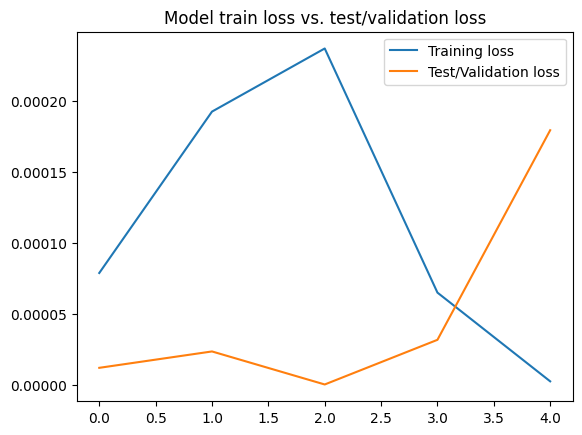

In [43]:
## plot train losses
plt.plot(train_losses, label="Training loss")
plt.plot(test_losses, label="Test/Validation loss")
plt.legend()
plt.title("Model train loss vs. test/validation loss")
plt.show()

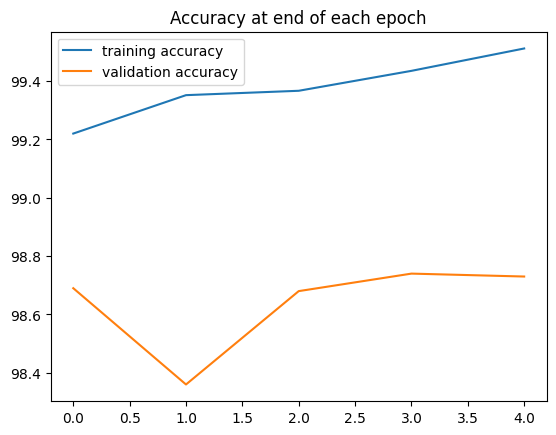

In [44]:
## plot accuracy
plt.plot([t/600 for t in train_correct], label="training accuracy")
plt.plot([t/100 for t in test_correct], label="validation accuracy")
plt.title("Accuracy at end of each epoch")
plt.legend()
plt.show;

In [45]:
## eval all test data
test_load_all = DataLoader(test_data, batch_size=10000,shuffle=False)


In [46]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_all:
    y_val = model(X_test)
    predicted = torch.max(y_val,1)[1]
    correct += (predicted == y_test).sum()

In [47]:
## how many correct?
correct.item()/len(test_data)

0.9873

Summary: 98.7% accuracy which is similar to the ANN in the first notebook but we are using about 50% less parameters with a CNN.

## Confusion Matrix

In [55]:
np.set_printoptions(formatter=dict(int=lambda x: f'{x:4}'))
print(np.arange(10).reshape(1,10))
print()

# print confusion matrix
print(confusion_matrix(predicted.view(-1), y_test.view(-1)))


[[   0    1    2    3    4    5    6    7    8    9]]

[[ 961    0    1    0    0    1    1    0    0    0]
 [   0 1129    0    1    0    0    2    3    0    0]
 [   2    0 1013    1    0    0    1    3    0    0]
 [   0    2    1 1001    0    5    0    0    2    0]
 [   0    0    1    0  966    0    1    0    0    5]
 [   0    1    0    3    0  884    3    1    2    6]
 [   6    2    1    0    6    1  949    0    0    0]
 [   3    0    9    1    1    0    0 1015    1    2]
 [   3    1    6    2    1    1    1    3  967    8]
 [   5    0    0    1    8    0    0    3    2  988]]


We can see the 7s and 8s had quite a few missing predictions.

# How can we run a new single image through model?

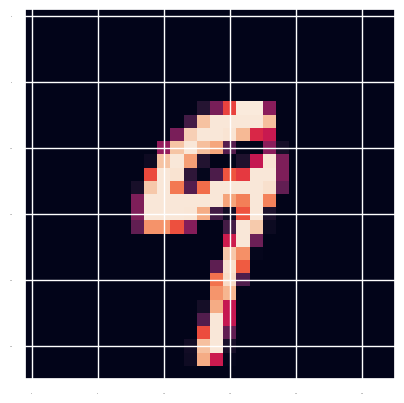

In [59]:
plt.imshow(test_data[2019][0].reshape(28,28))

## Pass this image through model

In [61]:
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[2019][0].view(1,1,28,28))


In [62]:
## new prediction with argmax()
new_prediction.argmax()

tensor(9)

Now we can see the prediction was correct.

## Let's try another one

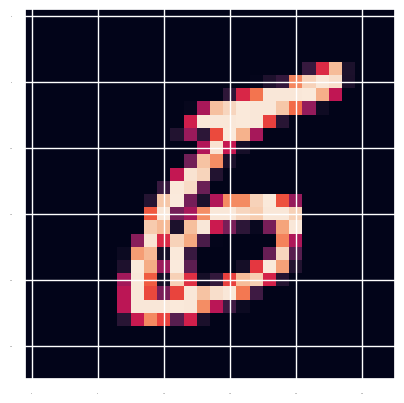

In [64]:
plt.imshow(test_data[1982][0].reshape(28,28))

In [65]:
## pass through model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[1982][0].view(1,1,28,28))


In [66]:
## make prediction
new_prediction.argmax()

tensor(6)

The model correctly predicted a 6

# Conclusion
* We were able to obtain similar accuracy results as the ANN using a CNN at 98% accuracy.
* The best thing about the CNN is it requires less parameters, less compute power and less time to train a neural network.